In [1]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())

Version 1.10.0+cu102
CUDA enabled: False


In [2]:
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import tqdm

import sys
import os
import pickle
import re
import csv
import multiprocessing

import pt_util

In [3]:
DATA_DIR = 'dakshina_dataset_v1.0'
LANG = 'ta'
LANG_DIR = 'lexicons'
DATA_PATH = '{}/{}/{}'.format(DATA_DIR, LANG, LANG_DIR)

In [4]:
def prepare_data(dirpath):
    # Read train and test data
    filenames = os.listdir(dirpath)
    train_data = []
    test_data = []
    max_len = 0 # max length of any word in the dataset
    
    def get_most_annotated_transliterations(tsv_file, data, max_len):
        curr_lang = None
        max_annotations = 0
        curr_translits = {}

        # only consider the most annotated transliteration(s) for each foreign language word
        for lang, en, annotations in tsv_file:
            if not curr_lang or lang != curr_lang:
                for translit, annots in curr_translits.items():
                    if annots == max_annotations:
                        data.append([curr_lang, translit])
                        max_len = max(max_len, len(translit))
                curr_lang = lang
                max_annotations = annotations
                curr_translits = {en: annotations}
                max_len = max(max_len, len(curr_lang))
            else:
                max_annotations = max(max_annotations, annotations)
                curr_translits[en] = annotations
        for translit, annots in curr_translits.items(): # fencepost
            if annots == max_annotations:
                data.append([curr_lang, translit])
                max_len = max(max_len, len(translit))
        return max_len
    
    for filename in filenames:
        with open(os.path.join(dirpath, filename), 'r') as file:
            tsv = csv.reader(file, delimiter='\t')
            if filename.endswith('train.tsv'):
                max_len = get_most_annotated_transliterations(tsv, train_data, max_len)
            else:
                max_len = get_most_annotated_transliterations(tsv, test_data, max_len)
                
    return train_data, test_data, max_len

In [5]:
PAD = '<PAD>'
def create_dictionaries(data):
    #en_voc2ind = {PAD: 0}
    #lang_voc2ind = {PAD: 0}
    #en_ind2voc = {0: PAD}
    #lang_ind2voc = {0: PAD}
    
    en_voc2ind = {}
    lang_voc2ind = {}
    en_ind2voc = {}
    lang_ind2voc = {}
    
    en_ind = 0 #1
    lang_ind = 0 #1
    for lang, en in data:
        for lang_char in lang:
            if lang_char not in lang_voc2ind:
                lang_voc2ind[lang_char] = lang_ind
                lang_ind2voc[lang_ind] = lang_char
                lang_ind += 1
        for en_char in en:
            if en_char not in en_voc2ind:
                en_voc2ind[en_char] = en_ind
                en_ind2voc[en_ind] = en_char
                en_ind += 1
                
    en_voc2ind[PAD] = en_ind
    lang_voc2ind[PAD] = lang_ind
    en_ind2voc[en_ind] = PAD
    lang_ind2voc[lang_ind] = PAD
    
    return lang_voc2ind, lang_ind2voc, en_voc2ind, en_ind2voc

In [6]:
# Preprocessing functions
def tokenize_data(data, voc2ind):
    return [voc2ind[char] for char in data]

def detokenize_and_depad_data(data, ind2voc, pad_val=0):
    res = []
    for ind in data:
        if ind.item() == pad_val:
            break
        res.append(ind2voc[ind.item()])
    return res

def pad_data(data, seq_len, pad_val=0):
    for _ in range(len(data), seq_len):
        data.append(pad_val)
    return data

In [7]:
class TransliterateDataset(torch.utils.data.Dataset):
    
    def __init__(self, data, lang_voc2ind, en_voc2ind, seq_len):
        super(TransliterateDataset, self).__init__()
        
        # Tokenize and pad data
        lang_data = []
        en_data = []
        for lang, en in data:
            lang_tokens = tokenize_data(lang, lang_voc2ind)
            lang_data.append(pad_data(lang_tokens, seq_len, len(lang_voc2ind) - 1))
            en_tokens = tokenize_data(en, en_voc2ind)
            en_data.append(pad_data(en_tokens, seq_len, len(en_voc2ind) - 1))
            
        self.language_data = lang_data
        self.english_data = en_data
        self.sequence_length = seq_len

    def __len__(self):
        return len(self.english_data)
        
    def __getitem__(self, idx):
        # Return the data and label at idx
        return torch.LongTensor(self.english_data[idx]), torch.LongTensor(self.language_data[idx])
    
    def get_random_sample(self):
        return self.__getitem__(np.random.randint(self.__len__()))

In [8]:
class TransliterateNet(nn.Module):
    
    def __init__(self, en_vocab_size, lang_vocab_size, feature_size):
        super(TransliterateNet, self).__init__()
        self.en_vocab_size = en_vocab_size
        self.lang_vocab_size = lang_vocab_size
        self.feature_size = feature_size

        self.encoder = nn.Embedding(self.en_vocab_size, self.feature_size)
        self.rnn = nn.RNN(self.feature_size, self.feature_size, 2)
        self.decoder = nn.Linear(self.feature_size, self.lang_vocab_size)
        
        #self.decoder.weight = self.encoder.weight
        #self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        x = self.encoder(x)
        x, hidden_state = self.rnn(x, hidden_state)
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.lang_vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

In [9]:
def repackage_hidden(h):
    # Wraps hidden states in new Tensors, to detach them from their history
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches.
        # Otherwise the backward would try to go all the way to the beginning every time
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader, en_ind2voc, lang_ind2voc):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    detokenize_and_depad_data(data[0], en_ind2voc, len(en_ind2voc) - 1),
                    detokenize_and_depad_data(label[0], lang_ind2voc, len(lang_ind2voc) - 1),
                    detokenize_and_depad_data(pred[0], lang_ind2voc, len(lang_ind2voc) - 1)))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cpu
num workers: 48
Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['்', 'ஷ', 'ௌ', 'ஜ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ே', 'ஷ', 'ஹ', 'ௌ']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['ை', 'ஷ', 'ஷ', '்', 'ஷ', 'ே', 'ஷ', 'ா', 'ஹ', 'ா', 'ய', 'ஐ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['ஷ', 'ஷ', 'ஷ', 'ஹ', 'ஷ', 'ஃ', 'ற', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ', 'ஷ']



Test set: Average loss: 3.7812, Accuracy: 1677/239760 (1%)



  1%|▏         | 1/76 [00:00<00:31,  2.39it/s]

Train Epoch: 0 [0/38723 (0%)]	Loss: 3.773700


 14%|█▍        | 11/76 [00:02<00:13,  4.97it/s]

Train Epoch: 0 [5120/38723 (13%)]	Loss: 1.084839


 28%|██▊       | 21/76 [00:04<00:10,  5.00it/s]

Train Epoch: 0 [10240/38723 (26%)]	Loss: 1.029131


 41%|████      | 31/76 [00:06<00:09,  4.98it/s]

Train Epoch: 0 [15360/38723 (39%)]	Loss: 1.057969


 55%|█████▌    | 42/76 [00:08<00:06,  5.09it/s]

Train Epoch: 0 [20480/38723 (53%)]	Loss: 1.015509


 68%|██████▊   | 52/76 [00:10<00:04,  5.07it/s]

Train Epoch: 0 [25600/38723 (66%)]	Loss: 0.960828


 82%|████████▏ | 62/76 [00:12<00:02,  5.00it/s]

Train Epoch: 0 [30720/38723 (79%)]	Loss: 0.931095


 95%|█████████▍| 72/76 [00:14<00:00,  5.05it/s]

Train Epoch: 0 [35840/38723 (92%)]	Loss: 0.976860


100%|██████████| 76/76 [00:15<00:00,  4.94it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['்', 'ெ', '்', '்', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ழ', '்', '்', '்', '்', '்', 'த', 'த']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'வ']



Test set: Average loss: 0.9213, Accuracy: 182819/239760 (76%)



  1%|▏         | 1/76 [00:00<00:13,  5.43it/s]

Train Epoch: 1 [0/38723 (0%)]	Loss: 1.047001


 16%|█▌        | 12/76 [00:02<00:12,  5.07it/s]

Train Epoch: 1 [5120/38723 (13%)]	Loss: 0.936652


 29%|██▉       | 22/76 [00:04<00:10,  5.07it/s]

Train Epoch: 1 [10240/38723 (26%)]	Loss: 1.033904


 41%|████      | 31/76 [00:06<00:08,  5.08it/s]

Train Epoch: 1 [15360/38723 (39%)]	Loss: 0.949082


 55%|█████▌    | 42/76 [00:08<00:06,  5.04it/s]

Train Epoch: 1 [20480/38723 (53%)]	Loss: 1.008595


 67%|██████▋   | 51/76 [00:10<00:04,  5.06it/s]

Train Epoch: 1 [25600/38723 (66%)]	Loss: 0.945646


 82%|████████▏ | 62/76 [00:12<00:02,  5.08it/s]

Train Epoch: 1 [30720/38723 (79%)]	Loss: 0.927605


 95%|█████████▍| 72/76 [00:14<00:00,  5.11it/s]

Train Epoch: 1 [35840/38723 (92%)]	Loss: 0.986792


100%|██████████| 76/76 [00:14<00:00,  5.09it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['்', 'ெ', '்', '்', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'ா', 'ர', 'ா', '்', 'ா', '்', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ோ', '்', '்', 'ட', '்']



Test set: Average loss: 0.9106, Accuracy: 182241/239760 (76%)



  1%|▏         | 1/76 [00:00<00:13,  5.41it/s]

Train Epoch: 2 [0/38723 (0%)]	Loss: 1.030037


 16%|█▌        | 12/76 [00:02<00:12,  5.08it/s]

Train Epoch: 2 [5120/38723 (13%)]	Loss: 0.878322


 29%|██▉       | 22/76 [00:04<00:10,  5.04it/s]

Train Epoch: 2 [10240/38723 (26%)]	Loss: 1.002720


 42%|████▏     | 32/76 [00:06<00:09,  4.68it/s]

Train Epoch: 2 [15360/38723 (39%)]	Loss: 0.952905


 55%|█████▌    | 42/76 [00:08<00:06,  5.06it/s]

Train Epoch: 2 [20480/38723 (53%)]	Loss: 1.008647


 68%|██████▊   | 52/76 [00:10<00:04,  5.09it/s]

Train Epoch: 2 [25600/38723 (66%)]	Loss: 0.932382


 80%|████████  | 61/76 [00:12<00:02,  5.12it/s]

Train Epoch: 2 [30720/38723 (79%)]	Loss: 0.902797


 95%|█████████▍| 72/76 [00:14<00:00,  5.06it/s]

Train Epoch: 2 [35840/38723 (92%)]	Loss: 0.948525


100%|██████████| 76/76 [00:15<00:00,  5.06it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['்', 'ெ', '்', 'ி', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'ா', 'ர', '்', '்', '்', '்', '்', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ோ']



Test set: Average loss: 0.9111, Accuracy: 182078/239760 (76%)



  1%|▏         | 1/76 [00:00<00:13,  5.39it/s]

Train Epoch: 3 [0/38723 (0%)]	Loss: 1.021304


 16%|█▌        | 12/76 [00:02<00:12,  5.06it/s]

Train Epoch: 3 [5120/38723 (13%)]	Loss: 0.895740


 29%|██▉       | 22/76 [00:04<00:10,  5.05it/s]

Train Epoch: 3 [10240/38723 (26%)]	Loss: 1.031395


 42%|████▏     | 32/76 [00:06<00:08,  5.07it/s]

Train Epoch: 3 [15360/38723 (39%)]	Loss: 0.963526


 55%|█████▌    | 42/76 [00:08<00:06,  5.09it/s]

Train Epoch: 3 [20480/38723 (53%)]	Loss: 1.004429


 68%|██████▊   | 52/76 [00:10<00:04,  5.07it/s]

Train Epoch: 3 [25600/38723 (66%)]	Loss: 0.931591


 80%|████████  | 61/76 [00:12<00:02,  5.02it/s]

Train Epoch: 3 [30720/38723 (79%)]	Loss: 0.906188


 95%|█████████▍| 72/76 [00:14<00:00,  5.02it/s]

Train Epoch: 3 [35840/38723 (92%)]	Loss: 0.950864


100%|██████████| 76/76 [00:14<00:00,  5.08it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['்', 'ெ', 'த', '்', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'ா', 'ர', 'ா', '்', 'ா', '்', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ோ', 'ர', '்', 'ோ', '்']



Test set: Average loss: 0.9055, Accuracy: 182558/239760 (76%)



  1%|▏         | 1/76 [00:00<00:15,  4.90it/s]

Train Epoch: 4 [0/38723 (0%)]	Loss: 0.958075


 16%|█▌        | 12/76 [00:02<00:12,  5.03it/s]

Train Epoch: 4 [5120/38723 (13%)]	Loss: 0.986516


 29%|██▉       | 22/76 [00:04<00:10,  5.07it/s]

Train Epoch: 4 [10240/38723 (26%)]	Loss: 1.010262


 42%|████▏     | 32/76 [00:06<00:08,  5.06it/s]

Train Epoch: 4 [15360/38723 (39%)]	Loss: 0.972253


 55%|█████▌    | 42/76 [00:08<00:06,  5.08it/s]

Train Epoch: 4 [20480/38723 (53%)]	Loss: 1.003519


 68%|██████▊   | 52/76 [00:10<00:04,  5.06it/s]

Train Epoch: 4 [25600/38723 (66%)]	Loss: 0.940964


 82%|████████▏ | 62/76 [00:12<00:02,  5.12it/s]

Train Epoch: 4 [30720/38723 (79%)]	Loss: 0.891452


 95%|█████████▍| 72/76 [00:14<00:00,  5.26it/s]

Train Epoch: 4 [35840/38723 (92%)]	Loss: 0.954444


100%|██████████| 76/76 [00:14<00:00,  5.12it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['்', 'ெ', '்', '்', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'ா', '்', '்', '்', '்', '்', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'வ']



Test set: Average loss: 0.8985, Accuracy: 183148/239760 (76%)



  1%|▏         | 1/76 [00:00<00:13,  5.40it/s]

Train Epoch: 5 [0/38723 (0%)]	Loss: 1.055995


 16%|█▌        | 12/76 [00:02<00:12,  5.11it/s]

Train Epoch: 5 [5120/38723 (13%)]	Loss: 0.861334


 29%|██▉       | 22/76 [00:04<00:10,  4.92it/s]

Train Epoch: 5 [10240/38723 (26%)]	Loss: 1.027299


 42%|████▏     | 32/76 [00:06<00:08,  5.17it/s]

Train Epoch: 5 [15360/38723 (39%)]	Loss: 0.931633


 55%|█████▌    | 42/76 [00:08<00:06,  5.08it/s]

Train Epoch: 5 [20480/38723 (53%)]	Loss: 1.001947


 68%|██████▊   | 52/76 [00:10<00:04,  5.04it/s]

Train Epoch: 5 [25600/38723 (66%)]	Loss: 0.912656


 80%|████████  | 61/76 [00:12<00:03,  4.99it/s]

Train Epoch: 5 [30720/38723 (79%)]	Loss: 0.902691


 93%|█████████▎| 71/76 [00:14<00:00,  5.00it/s]

Train Epoch: 5 [35840/38723 (92%)]	Loss: 0.950111


100%|██████████| 76/76 [00:15<00:00,  5.01it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ர', 'ம']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['்', 'ெ', '்', '்', '்']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', '்', 'ர', '்', '்', '்', '்', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ட']



Test set: Average loss: 0.8956, Accuracy: 183566/239760 (77%)



  1%|▏         | 1/76 [00:00<00:13,  5.39it/s]

Train Epoch: 6 [0/38723 (0%)]	Loss: 1.010990


 16%|█▌        | 12/76 [00:02<00:12,  5.08it/s]

Train Epoch: 6 [5120/38723 (13%)]	Loss: 0.925431


 29%|██▉       | 22/76 [00:04<00:10,  5.04it/s]

Train Epoch: 6 [10240/38723 (26%)]	Loss: 1.013516


 42%|████▏     | 32/76 [00:06<00:08,  5.04it/s]

Train Epoch: 6 [15360/38723 (39%)]	Loss: 0.952749


 55%|█████▌    | 42/76 [00:08<00:06,  5.05it/s]

Train Epoch: 6 [20480/38723 (53%)]	Loss: 0.993121


 67%|██████▋   | 51/76 [00:10<00:05,  4.86it/s]

Train Epoch: 6 [25600/38723 (66%)]	Loss: 0.912143


 82%|████████▏ | 62/76 [00:12<00:02,  5.09it/s]

Train Epoch: 6 [30720/38723 (79%)]	Loss: 0.894750


 95%|█████████▍| 72/76 [00:14<00:00,  5.04it/s]

Train Epoch: 6 [35840/38723 (92%)]	Loss: 0.941731


100%|██████████| 76/76 [00:14<00:00,  5.07it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ர', 'ம']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['்', 'ெ', 'த', 'ி', '்']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'ா', 'ர', '்', '்', '்', '்', '்', '்', 'ி', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ோ', '்', '்', 'ோ', 'ங']



Test set: Average loss: 0.9043, Accuracy: 182051/239760 (76%)



  1%|▏         | 1/76 [00:00<00:14,  5.35it/s]

Train Epoch: 7 [0/38723 (0%)]	Loss: 1.024875


 16%|█▌        | 12/76 [00:02<00:12,  5.01it/s]

Train Epoch: 7 [5120/38723 (13%)]	Loss: 0.901949


 29%|██▉       | 22/76 [00:04<00:10,  5.06it/s]

Train Epoch: 7 [10240/38723 (26%)]	Loss: 1.011550


 42%|████▏     | 32/76 [00:06<00:08,  5.04it/s]

Train Epoch: 7 [15360/38723 (39%)]	Loss: 0.942167


 55%|█████▌    | 42/76 [00:08<00:06,  5.08it/s]

Train Epoch: 7 [20480/38723 (53%)]	Loss: 1.031164


 68%|██████▊   | 52/76 [00:10<00:04,  5.05it/s]

Train Epoch: 7 [25600/38723 (66%)]	Loss: 0.930277


 82%|████████▏ | 62/76 [00:12<00:02,  5.04it/s]

Train Epoch: 7 [30720/38723 (79%)]	Loss: 0.891642


 95%|█████████▍| 72/76 [00:14<00:00,  5.03it/s]

Train Epoch: 7 [35840/38723 (92%)]	Loss: 0.950172


100%|██████████| 76/76 [00:15<00:00,  5.07it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ர', 'ம']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['்', 'ெ', '்', '்', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'ா', 'ர', 'ா', '்', 'ா', '்', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ா']



Test set: Average loss: 0.9058, Accuracy: 182223/239760 (76%)



  3%|▎         | 2/76 [00:00<00:14,  5.01it/s]

Train Epoch: 8 [0/38723 (0%)]	Loss: 1.032139


 16%|█▌        | 12/76 [00:02<00:12,  5.02it/s]

Train Epoch: 8 [5120/38723 (13%)]	Loss: 0.931700


 29%|██▉       | 22/76 [00:04<00:10,  5.04it/s]

Train Epoch: 8 [10240/38723 (26%)]	Loss: 1.007336


 42%|████▏     | 32/76 [00:06<00:08,  5.02it/s]

Train Epoch: 8 [15360/38723 (39%)]	Loss: 0.932247


 55%|█████▌    | 42/76 [00:08<00:06,  5.01it/s]

Train Epoch: 8 [20480/38723 (53%)]	Loss: 0.976367


 68%|██████▊   | 52/76 [00:10<00:04,  5.08it/s]

Train Epoch: 8 [25600/38723 (66%)]	Loss: 0.913809


 82%|████████▏ | 62/76 [00:12<00:02,  5.05it/s]

Train Epoch: 8 [30720/38723 (79%)]	Loss: 0.909338


 95%|█████████▍| 72/76 [00:14<00:00,  5.05it/s]

Train Epoch: 8 [35840/38723 (92%)]	Loss: 0.943127


100%|██████████| 76/76 [00:15<00:00,  5.06it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['்', 'ெ', '்']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', '்', '்', '்', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ா', 'ர', '்', 'ப', '்']



Test set: Average loss: 0.9043, Accuracy: 182590/239760 (76%)



  1%|▏         | 1/76 [00:00<00:13,  5.39it/s]

Train Epoch: 9 [0/38723 (0%)]	Loss: 1.046376


 16%|█▌        | 12/76 [00:02<00:12,  5.02it/s]

Train Epoch: 9 [5120/38723 (13%)]	Loss: 0.925154


 29%|██▉       | 22/76 [00:04<00:10,  5.06it/s]

Train Epoch: 9 [10240/38723 (26%)]	Loss: 1.001751


 42%|████▏     | 32/76 [00:06<00:08,  5.07it/s]

Train Epoch: 9 [15360/38723 (39%)]	Loss: 0.948955


 55%|█████▌    | 42/76 [00:08<00:06,  5.06it/s]

Train Epoch: 9 [20480/38723 (53%)]	Loss: 0.992910


 67%|██████▋   | 51/76 [00:10<00:04,  5.08it/s]

Train Epoch: 9 [25600/38723 (66%)]	Loss: 0.922125


 82%|████████▏ | 62/76 [00:12<00:02,  5.03it/s]

Train Epoch: 9 [30720/38723 (79%)]	Loss: 0.890907


 95%|█████████▍| 72/76 [00:14<00:00,  4.98it/s]

Train Epoch: 9 [35840/38723 (92%)]	Loss: 0.935672


100%|██████████| 76/76 [00:15<00:00,  5.05it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ர', 'ம']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['்', 'ெ', '்', '்', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'ா', 'ர', 'ா', '்', 'ட', '்', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ோ']



Test set: Average loss: 0.8960, Accuracy: 183000/239760 (76%)



  1%|▏         | 1/76 [00:00<00:13,  5.38it/s]

Train Epoch: 10 [0/38723 (0%)]	Loss: 1.043501


 14%|█▍        | 11/76 [00:02<00:12,  5.03it/s]

Train Epoch: 10 [5120/38723 (13%)]	Loss: 0.903531


 29%|██▉       | 22/76 [00:04<00:10,  5.07it/s]

Train Epoch: 10 [10240/38723 (26%)]	Loss: 1.008012


 42%|████▏     | 32/76 [00:06<00:08,  5.05it/s]

Train Epoch: 10 [15360/38723 (39%)]	Loss: 0.935474


 55%|█████▌    | 42/76 [00:08<00:06,  5.02it/s]

Train Epoch: 10 [20480/38723 (53%)]	Loss: 0.995466


 68%|██████▊   | 52/76 [00:10<00:04,  5.04it/s]

Train Epoch: 10 [25600/38723 (66%)]	Loss: 0.914468


 82%|████████▏ | 62/76 [00:12<00:02,  5.05it/s]

Train Epoch: 10 [30720/38723 (79%)]	Loss: 0.867375


 95%|█████████▍| 72/76 [00:14<00:00,  5.05it/s]

Train Epoch: 10 [35840/38723 (92%)]	Loss: 0.921958


100%|██████████| 76/76 [00:14<00:00,  5.07it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', '்', 'ர', 'ம']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['்', 'ெ', '்', '்', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'ா', 'ர', '்', '்', '்', 'ட', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ா']



Test set: Average loss: 0.8976, Accuracy: 183765/239760 (77%)



  1%|▏         | 1/76 [00:00<00:14,  5.33it/s]

Train Epoch: 11 [0/38723 (0%)]	Loss: 0.998159


 16%|█▌        | 12/76 [00:02<00:12,  5.00it/s]

Train Epoch: 11 [5120/38723 (13%)]	Loss: 0.930025


 29%|██▉       | 22/76 [00:04<00:10,  5.00it/s]

Train Epoch: 11 [10240/38723 (26%)]	Loss: 1.025099


 41%|████      | 31/76 [00:06<00:08,  5.02it/s]

Train Epoch: 11 [15360/38723 (39%)]	Loss: 0.954412


 55%|█████▌    | 42/76 [00:08<00:06,  5.04it/s]

Train Epoch: 11 [20480/38723 (53%)]	Loss: 0.985928


 68%|██████▊   | 52/76 [00:10<00:04,  5.05it/s]

Train Epoch: 11 [25600/38723 (66%)]	Loss: 0.918779


 80%|████████  | 61/76 [00:12<00:03,  4.98it/s]

Train Epoch: 11 [30720/38723 (79%)]	Loss: 0.873394


 93%|█████████▎| 71/76 [00:14<00:00,  5.01it/s]

Train Epoch: 11 [35840/38723 (92%)]	Loss: 0.935864


100%|██████████| 76/76 [00:15<00:00,  5.04it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'க', 'ர']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['்', 'ெ', '்', '்', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'வ', 'ர', '்', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ட', '்', '்', 'ட', '்']



Test set: Average loss: 0.8884, Accuracy: 183485/239760 (77%)



  1%|▏         | 1/76 [00:00<00:14,  5.28it/s]

Train Epoch: 12 [0/38723 (0%)]	Loss: 1.003879


 16%|█▌        | 12/76 [00:02<00:12,  5.00it/s]

Train Epoch: 12 [5120/38723 (13%)]	Loss: 0.901150


 28%|██▊       | 21/76 [00:04<00:11,  4.96it/s]

Train Epoch: 12 [10240/38723 (26%)]	Loss: 1.028860


 41%|████      | 31/76 [00:06<00:09,  4.98it/s]

Train Epoch: 12 [15360/38723 (39%)]	Loss: 0.948454


 54%|█████▍    | 41/76 [00:08<00:07,  4.98it/s]

Train Epoch: 12 [20480/38723 (53%)]	Loss: 1.004272


 67%|██████▋   | 51/76 [00:10<00:05,  4.97it/s]

Train Epoch: 12 [25600/38723 (66%)]	Loss: 0.919990


 82%|████████▏ | 62/76 [00:12<00:02,  5.01it/s]

Train Epoch: 12 [30720/38723 (79%)]	Loss: 0.886411


 93%|█████████▎| 71/76 [00:14<00:01,  5.00it/s]

Train Epoch: 12 [35840/38723 (92%)]	Loss: 0.950294


100%|██████████| 76/76 [00:15<00:00,  4.99it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['்', 'ெ', '்', '்', '்']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ோ', 'ச', '்', 'ா', 'ங']



Test set: Average loss: 0.8981, Accuracy: 182991/239760 (76%)



  1%|▏         | 1/76 [00:00<00:14,  5.23it/s]

Train Epoch: 13 [0/38723 (0%)]	Loss: 1.042312


 16%|█▌        | 12/76 [00:02<00:12,  5.00it/s]

Train Epoch: 13 [5120/38723 (13%)]	Loss: 0.972841


 28%|██▊       | 21/76 [00:04<00:11,  4.98it/s]

Train Epoch: 13 [10240/38723 (26%)]	Loss: 1.029401


 41%|████      | 31/76 [00:06<00:09,  4.99it/s]

Train Epoch: 13 [15360/38723 (39%)]	Loss: 0.962671


 54%|█████▍    | 41/76 [00:08<00:07,  4.96it/s]

Train Epoch: 13 [20480/38723 (53%)]	Loss: 0.988136


 68%|██████▊   | 52/76 [00:10<00:04,  4.98it/s]

Train Epoch: 13 [25600/38723 (66%)]	Loss: 0.934006


 80%|████████  | 61/76 [00:12<00:03,  4.98it/s]

Train Epoch: 13 [30720/38723 (79%)]	Loss: 0.885732


 93%|█████████▎| 71/76 [00:14<00:01,  4.99it/s]

Train Epoch: 13 [35840/38723 (92%)]	Loss: 0.946792


100%|██████████| 76/76 [00:15<00:00,  5.01it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['்', 'ெ', '்', '்', '்']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'ா', '்', '்', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ட']



Test set: Average loss: 0.8867, Accuracy: 183371/239760 (76%)



  1%|▏         | 1/76 [00:00<00:14,  5.24it/s]

Train Epoch: 14 [0/38723 (0%)]	Loss: 1.012743


 14%|█▍        | 11/76 [00:02<00:13,  4.98it/s]

Train Epoch: 14 [5120/38723 (13%)]	Loss: 0.891550


 29%|██▉       | 22/76 [00:04<00:10,  5.00it/s]

Train Epoch: 14 [10240/38723 (26%)]	Loss: 1.016572


 42%|████▏     | 32/76 [00:06<00:08,  4.99it/s]

Train Epoch: 14 [15360/38723 (39%)]	Loss: 0.945284


 54%|█████▍    | 41/76 [00:08<00:07,  4.99it/s]

Train Epoch: 14 [20480/38723 (53%)]	Loss: 0.990324


 67%|██████▋   | 51/76 [00:10<00:04,  5.01it/s]

Train Epoch: 14 [25600/38723 (66%)]	Loss: 0.913052


 80%|████████  | 61/76 [00:12<00:03,  4.98it/s]

Train Epoch: 14 [30720/38723 (79%)]	Loss: 0.892531


 93%|█████████▎| 71/76 [00:14<00:01,  4.99it/s]

Train Epoch: 14 [35840/38723 (92%)]	Loss: 0.939005


100%|██████████| 76/76 [00:15<00:00,  5.01it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['்', 'ெ', '்', '்', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', '்', 'ர', '்', '்', '்', '்', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', '்', '்', '்', 'ர', '்']



Test set: Average loss: 0.9026, Accuracy: 182406/239760 (76%)



  1%|▏         | 1/76 [00:00<00:14,  5.29it/s]

Train Epoch: 15 [0/38723 (0%)]	Loss: 1.031870


 16%|█▌        | 12/76 [00:02<00:12,  4.94it/s]

Train Epoch: 15 [5120/38723 (13%)]	Loss: 0.908554


 29%|██▉       | 22/76 [00:04<00:10,  5.05it/s]

Train Epoch: 15 [10240/38723 (26%)]	Loss: 1.021050


 42%|████▏     | 32/76 [00:06<00:08,  5.07it/s]

Train Epoch: 15 [15360/38723 (39%)]	Loss: 0.925070


 55%|█████▌    | 42/76 [00:08<00:06,  5.07it/s]

Train Epoch: 15 [20480/38723 (53%)]	Loss: 0.988796


 68%|██████▊   | 52/76 [00:10<00:04,  5.08it/s]

Train Epoch: 15 [25600/38723 (66%)]	Loss: 0.937518


 82%|████████▏ | 62/76 [00:12<00:02,  5.06it/s]

Train Epoch: 15 [30720/38723 (79%)]	Loss: 0.889656


 95%|█████████▍| 72/76 [00:14<00:00,  5.08it/s]

Train Epoch: 15 [35840/38723 (92%)]	Loss: 0.938391


100%|██████████| 76/76 [00:14<00:00,  5.08it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'க', 'ர', 'ம']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['்', 'ெ', '்', '்']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'ா', 'ர', '்', '்', '்', '்', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ோ', '்', '்']



Test set: Average loss: 0.8959, Accuracy: 182004/239760 (76%)



  1%|▏         | 1/76 [00:00<00:14,  5.34it/s]

Train Epoch: 16 [0/38723 (0%)]	Loss: 1.018579


 16%|█▌        | 12/76 [00:02<00:12,  5.05it/s]

Train Epoch: 16 [5120/38723 (13%)]	Loss: 0.897881


 29%|██▉       | 22/76 [00:04<00:10,  5.06it/s]

Train Epoch: 16 [10240/38723 (26%)]	Loss: 1.029755


 42%|████▏     | 32/76 [00:06<00:08,  5.04it/s]

Train Epoch: 16 [15360/38723 (39%)]	Loss: 0.967391


 55%|█████▌    | 42/76 [00:08<00:06,  5.03it/s]

Train Epoch: 16 [20480/38723 (53%)]	Loss: 0.996492


 68%|██████▊   | 52/76 [00:10<00:04,  5.05it/s]

Train Epoch: 16 [25600/38723 (66%)]	Loss: 0.931345


 82%|████████▏ | 62/76 [00:12<00:02,  5.01it/s]

Train Epoch: 16 [30720/38723 (79%)]	Loss: 0.888167


 95%|█████████▍| 72/76 [00:14<00:00,  5.05it/s]

Train Epoch: 16 [35840/38723 (92%)]	Loss: 0.932317


100%|██████████| 76/76 [00:14<00:00,  5.07it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ர', 'ம']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['்', 'ெ', '்', '்', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', '்', '்', '்', '்', '்', '்', '்', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ழ', '்', '்', 'ட', '்']



Test set: Average loss: 0.8965, Accuracy: 183457/239760 (77%)



  1%|▏         | 1/76 [00:00<00:13,  5.38it/s]

Train Epoch: 17 [0/38723 (0%)]	Loss: 1.036370


 16%|█▌        | 12/76 [00:02<00:13,  4.68it/s]

Train Epoch: 17 [5120/38723 (13%)]	Loss: 0.911290


 29%|██▉       | 22/76 [00:04<00:10,  5.05it/s]

Train Epoch: 17 [10240/38723 (26%)]	Loss: 1.013102


 42%|████▏     | 32/76 [00:06<00:08,  5.03it/s]

Train Epoch: 17 [15360/38723 (39%)]	Loss: 0.966223


 55%|█████▌    | 42/76 [00:08<00:06,  5.02it/s]

Train Epoch: 17 [20480/38723 (53%)]	Loss: 0.990890


 68%|██████▊   | 52/76 [00:10<00:04,  5.04it/s]

Train Epoch: 17 [25600/38723 (66%)]	Loss: 0.900536


 82%|████████▏ | 62/76 [00:12<00:02,  5.03it/s]

Train Epoch: 17 [30720/38723 (79%)]	Loss: 0.869586


 95%|█████████▍| 72/76 [00:14<00:00,  5.03it/s]

Train Epoch: 17 [35840/38723 (92%)]	Loss: 0.932425


100%|██████████| 76/76 [00:15<00:00,  5.05it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'வ', 'ர', 'ம']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['்', 'ெ', '்', '்', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ழ', '்', '்', 'ட', '்']



Test set: Average loss: 0.9016, Accuracy: 182919/239760 (76%)



  1%|▏         | 1/76 [00:00<00:13,  5.38it/s]

Train Epoch: 18 [0/38723 (0%)]	Loss: 1.036052


 16%|█▌        | 12/76 [00:02<00:12,  5.04it/s]

Train Epoch: 18 [5120/38723 (13%)]	Loss: 0.921146


 29%|██▉       | 22/76 [00:04<00:10,  5.07it/s]

Train Epoch: 18 [10240/38723 (26%)]	Loss: 1.019368


 42%|████▏     | 32/76 [00:06<00:08,  5.08it/s]

Train Epoch: 18 [15360/38723 (39%)]	Loss: 0.920185


 55%|█████▌    | 42/76 [00:08<00:06,  5.05it/s]

Train Epoch: 18 [20480/38723 (53%)]	Loss: 0.999754


 68%|██████▊   | 52/76 [00:10<00:04,  5.05it/s]

Train Epoch: 18 [25600/38723 (66%)]	Loss: 0.915281


 82%|████████▏ | 62/76 [00:12<00:02,  5.06it/s]

Train Epoch: 18 [30720/38723 (79%)]	Loss: 0.867193


 95%|█████████▍| 72/76 [00:14<00:00,  5.04it/s]

Train Epoch: 18 [35840/38723 (92%)]	Loss: 0.923576


100%|██████████| 76/76 [00:14<00:00,  5.09it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ர', 'ம']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['்', 'ெ', '்', '்', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ோ', 'ச', '்']



Test set: Average loss: 0.8809, Accuracy: 183273/239760 (76%)



  1%|▏         | 1/76 [00:00<00:13,  5.41it/s]

Train Epoch: 19 [0/38723 (0%)]	Loss: 0.933204


 16%|█▌        | 12/76 [00:02<00:12,  5.05it/s]

Train Epoch: 19 [5120/38723 (13%)]	Loss: 0.893430


 29%|██▉       | 22/76 [00:04<00:10,  5.04it/s]

Train Epoch: 19 [10240/38723 (26%)]	Loss: 1.042273


 42%|████▏     | 32/76 [00:06<00:08,  5.06it/s]

Train Epoch: 19 [15360/38723 (39%)]	Loss: 0.914803


 55%|█████▌    | 42/76 [00:08<00:06,  5.06it/s]

Train Epoch: 19 [20480/38723 (53%)]	Loss: 0.984442


 68%|██████▊   | 52/76 [00:10<00:04,  5.04it/s]

Train Epoch: 19 [25600/38723 (66%)]	Loss: 0.899507


 82%|████████▏ | 62/76 [00:12<00:02,  5.05it/s]

Train Epoch: 19 [30720/38723 (79%)]	Loss: 0.885595


 95%|█████████▍| 72/76 [00:14<00:00,  5.01it/s]

Train Epoch: 19 [35840/38723 (92%)]	Loss: 0.918733


100%|██████████| 76/76 [00:15<00:00,  5.05it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ஃ', 'ா', 'ர', 'ம']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['்', 'ெ', '்', '்']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', '்', 'ர', '்', '்', '்', '்', '்', '்', 'ி', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ர', '்', '்', 'ர', '்']



Test set: Average loss: 0.8952, Accuracy: 182611/239760 (76%)



  1%|▏         | 1/76 [00:00<00:13,  5.39it/s]

Train Epoch: 20 [0/38723 (0%)]	Loss: 1.033589


 16%|█▌        | 12/76 [00:02<00:12,  5.06it/s]

Train Epoch: 20 [5120/38723 (13%)]	Loss: 0.914589


 29%|██▉       | 22/76 [00:04<00:10,  5.06it/s]

Train Epoch: 20 [10240/38723 (26%)]	Loss: 1.029139


 42%|████▏     | 32/76 [00:06<00:08,  5.05it/s]

Train Epoch: 20 [15360/38723 (39%)]	Loss: 0.943165


 55%|█████▌    | 42/76 [00:08<00:06,  5.05it/s]

Train Epoch: 20 [20480/38723 (53%)]	Loss: 1.004858


 68%|██████▊   | 52/76 [00:10<00:04,  5.04it/s]

Train Epoch: 20 [25600/38723 (66%)]	Loss: 0.912012


 82%|████████▏ | 62/76 [00:12<00:02,  5.03it/s]

Train Epoch: 20 [30720/38723 (79%)]	Loss: 0.884084


 95%|█████████▍| 72/76 [00:14<00:00,  5.04it/s]

Train Epoch: 20 [35840/38723 (92%)]	Loss: 0.938906


100%|██████████| 76/76 [00:14<00:00,  5.07it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ஃ', 'ா', 'ர', 'ம']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['்', 'ெ', '்', '்', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', '்', 'ர', '்', '்', '்', '்', '்', '்', 'ி', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ோ', 'ச', '்', 'வ', '்']



Test set: Average loss: 0.9098, Accuracy: 181530/239760 (76%)



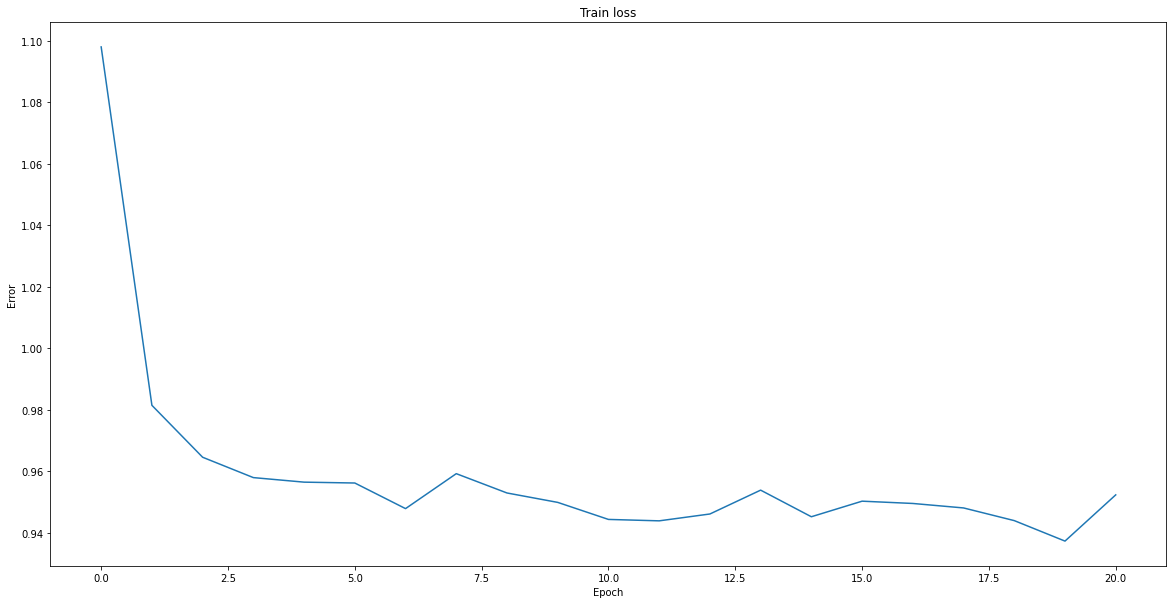

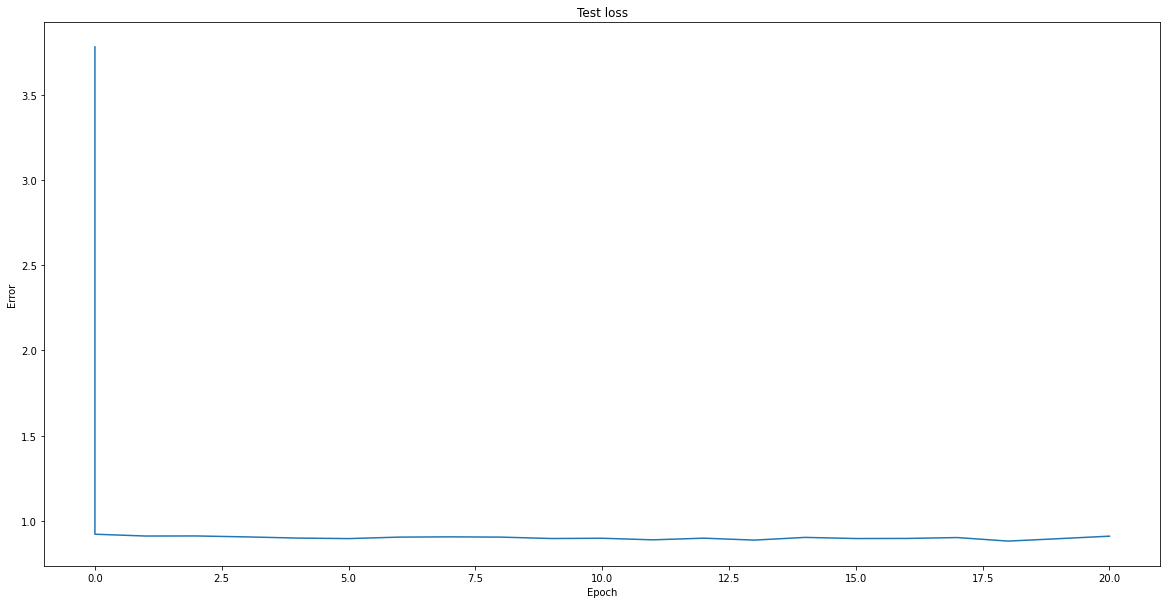

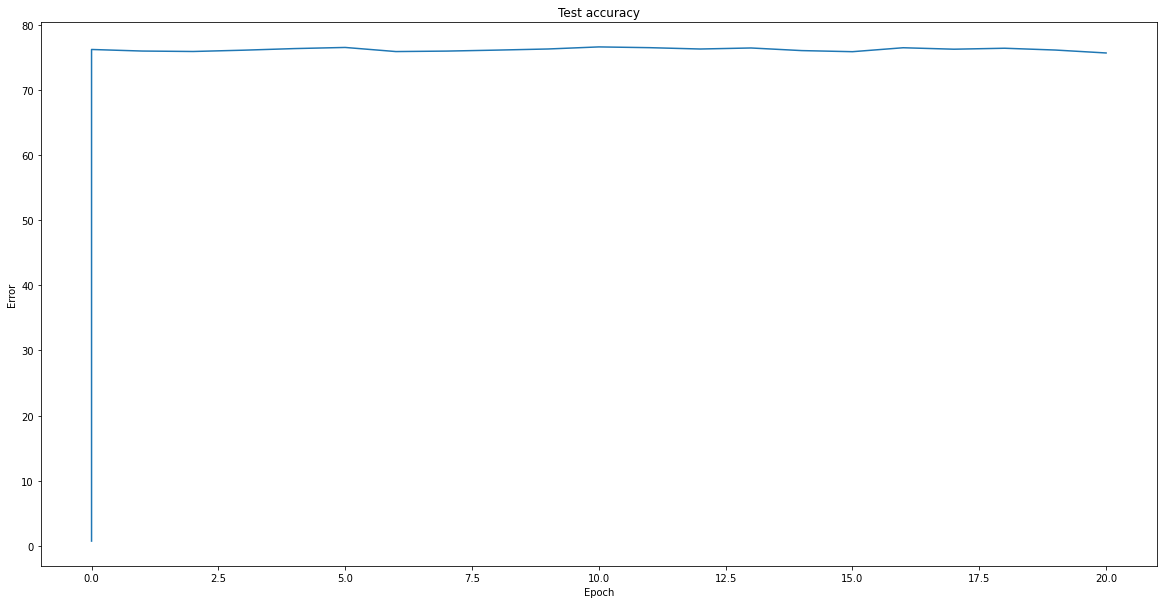

In [10]:
def main():
    BATCH_SIZE = 512
    FEATURE_SIZE = 128
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.005
    MOMENTUM = 0.9
    WEIGHT_DECAY = 0.000005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    OUT_PATH = 'out/'
    LOG_PATH = OUT_PATH + 'logs/log.pkl'
    
    train_data, test_data, seq_len = prepare_data(DATA_PATH)
    lang_voc2ind, lang_ind2voc, en_voc2ind, en_ind2voc = create_dictionaries(train_data + test_data)
    train_dataset = TransliterateDataset(train_data, lang_voc2ind, en_voc2ind, seq_len)
    test_dataset = TransliterateDataset(test_data, lang_voc2ind, en_voc2ind, seq_len)
    
    use_cuda = USE_CUDA and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)
    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)
    
    model = TransliterateNet(len(en_voc2ind), len(lang_voc2ind), FEATURE_SIZE).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    #optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(OUT_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader, en_ind2voc, lang_ind2voc)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))
    
    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader, en_ind2voc, lang_ind2voc)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            #pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            #model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        #print('Saving final model')
        #model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, en_voc2ind, lang_ind2voc, device
    
final_model, en_voc2ind, lang_ind2voc, device = main()

In [11]:
def generate_transliteration(model, word, en_voc2ind, lang_ind2voc, seq_len=30):
    transliteration = []
    hidden = None
    
    en_tokens = tokenize_data(word, en_voc2ind)
    en_data = torch.LongTensor(pad_data(en_tokens, seq_len))
    
    for c in torch.LongTensor(en_data):
        x, hidden = model.inference(c, hidden)
        transliteration.append(torch.argmax(x))
    
    return detokenize_and_depad_data(transliteration, lang_ind2voc, len(lang_ind2voc) - 1)

In [12]:
print(generate_transliteration(final_model, 'farm', en_voc2ind, lang_ind2voc)) # should ideally say 'ஃபார்ம்'

['ஃ', 'ஆ', 'ஐ', 'ஆ', 'ம', 'ூ', 'ூ', 'ஆ', 'ஃ', 'ஐ', 'ஐ', 'ஐ', 'ஃ', 'ஃ', 'ஃ', 'ஃ', 'ஜ', 'ஜ', 'ஜ', 'ஜ', 'ஜ', 'ஜ', 'ஜ', 'ஜ', 'ஜ', 'ஜ', 'ஜ', 'ஜ', 'ஜ', 'ஜ']
